In [12]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Build a baseline model

We are interested in testing the following alternative hypothesis:
1. Higher square footage increases home sale price.
2. The house filling a higher proportion of the overall lot decreases home sale price
3. The cost per square foot is lower in duplexes than in single-family homes

Therefore we have decided that our baseline model should include the following features:
1. Total living space, squarefeet
2. Total lot size, squarefeet
3. The ratio of house footprint to lot size. To engineer this feature we assumed the footprint was reasonably represented by the attached garage space+the first floor square feet divided by the lot size. 
4. If the house is a duplex, or not


## Cleaning Thought Process

Some top level thoughts are: we removed sales below $10,000, as these are most likely erroneous or a result from a sale from family to family. There are some mobile homes in the $30,000-50,000 range, and so we decided to err on the lower side as perhaps there are legitimate sales in the $10,000-$20,000 range. 

Also due to our business goals, of helping millennials buy their first home, we removed saleprices outside of two standard deviations of the mean. This excluded houses sold for more than $2.5 million. Our reasoning being that houses beyond that are certainly well outside the ability of a first-time buyer to achieve.

In [ ]:
from src.utilities import kc_housing as kc
df = kc.pullsqldata()
df_clean = kc.clean_data_intial(df)
x = df_clean.drop(columns = 'saleprice')
y = df_clean['saleprice']

In [14]:
kc.baseline_features = ['sqfttotliving','sqftlot','footprint_ratio','duplex']
kc.make_housing_model(baseline_features, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     3143.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        15:36:40   Log-Likelihood:            -3.9364e+05
No. Observations:               28037   AIC:                         7.873e+05
Df Residuals:                   28032   BIC:                         7.873e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.855e+05   6144.600     30.181      0.000    1.73e+05    1.97e+05
sqfttotliving     225.0720      2.143    105.008      0.000     220.871     229.273
sqftlot            -0.3505      0.155     -2.258      0.024      -0.655      -0.046
footprint_ratio  2.741e+05   1.79e+04     15.342      0.000    2.39e+05    3.09e+05
duplex            6.69e+04   1.64e+04      4.076      0.000    3.47e+04    9.91e+04
==============================================================================
Omnibus:                     2903.960   Durbin-Watson:                   0.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5901.363
Skew:                           0.671   Prob(JB):                         0.00
Kurtosis:                       4.803   Cond. No.                     1.82e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Check baseline model assumptions

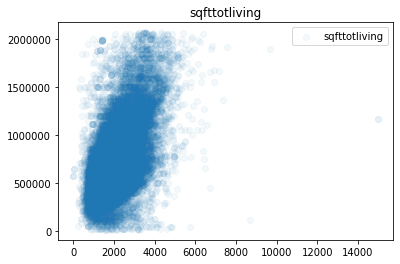

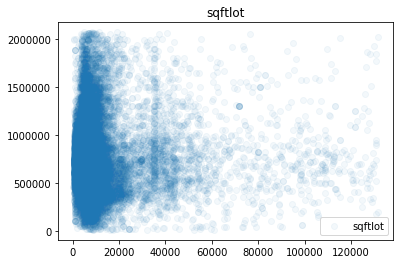

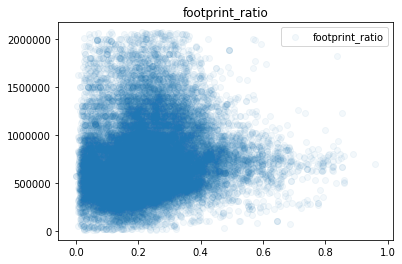

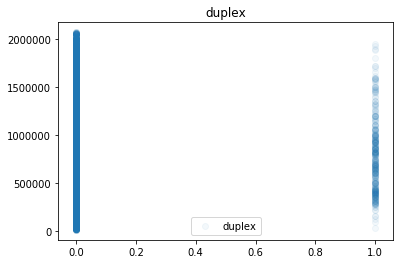

In [15]:
kc.check_feature_linearity(baseline_features, x, y)

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/brentsair/Documents/Flatiron_School/mod2/king_county/src/utilities/kc_housing.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


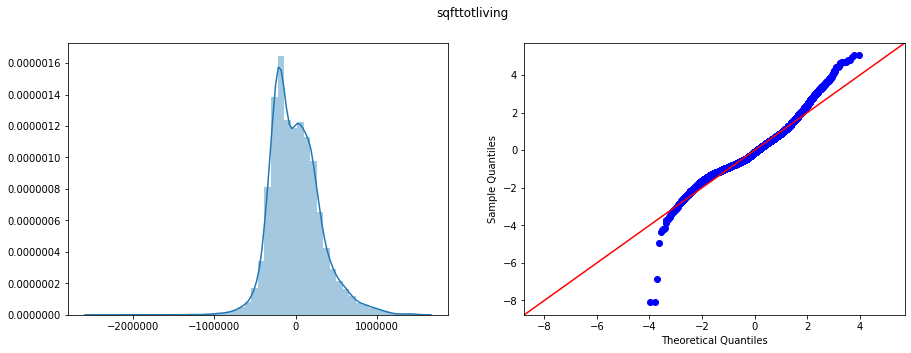

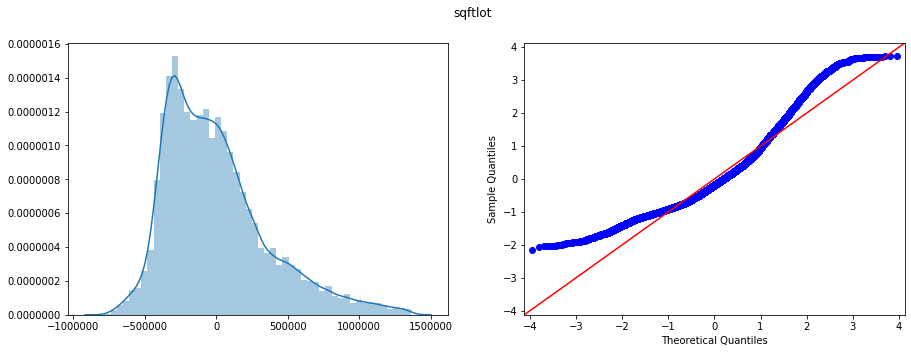

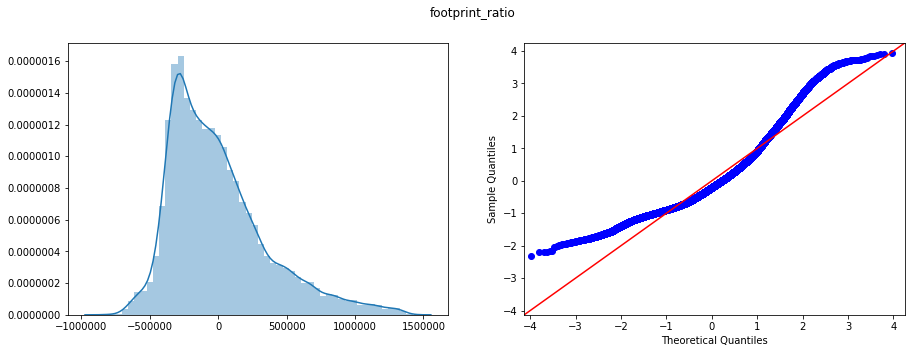

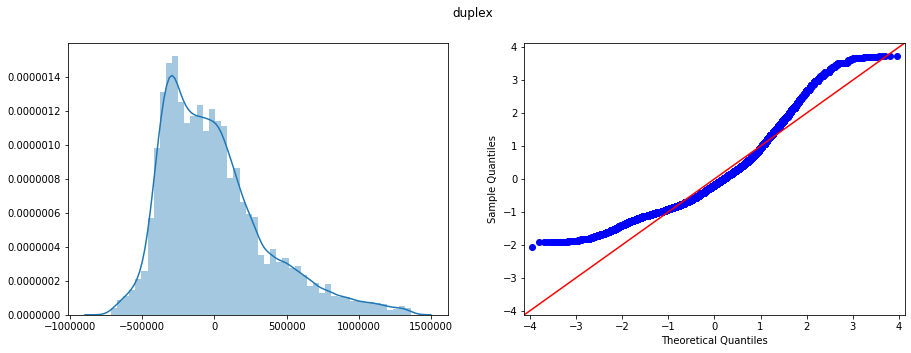

In [18]:
kc.check_feature_resid_dist(baseline_features, x, y)

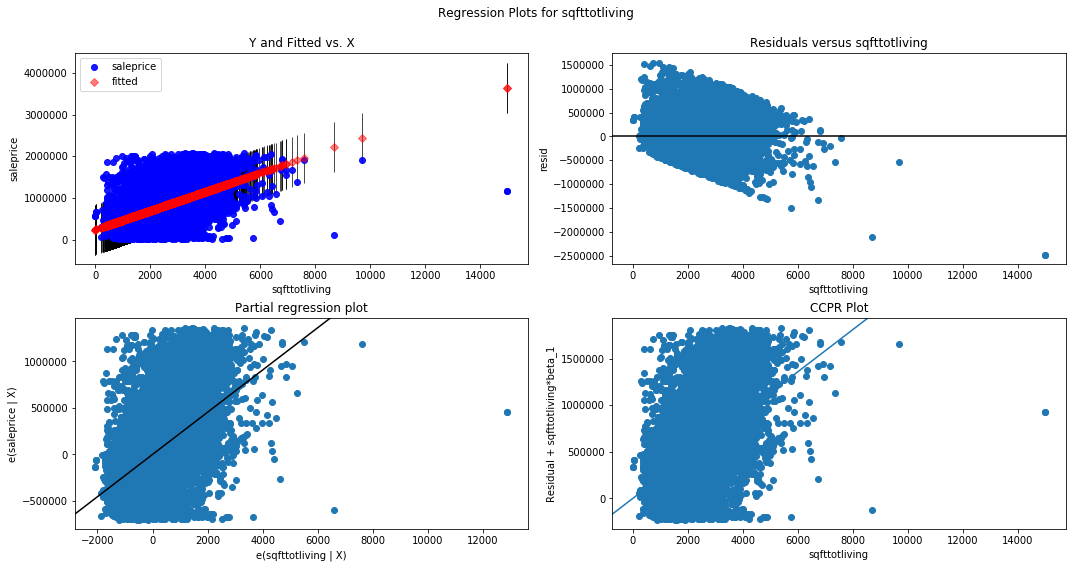

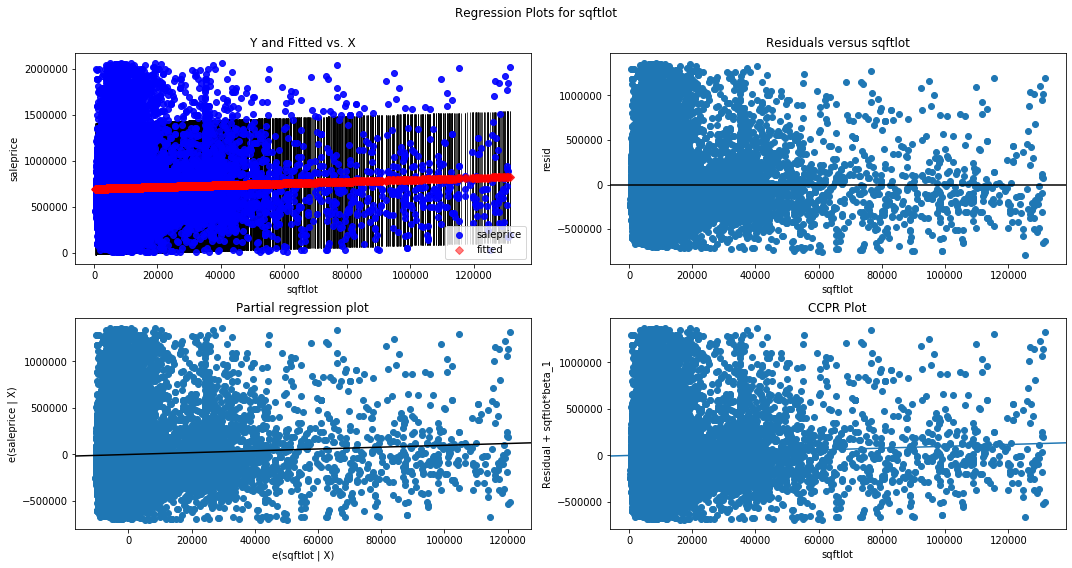

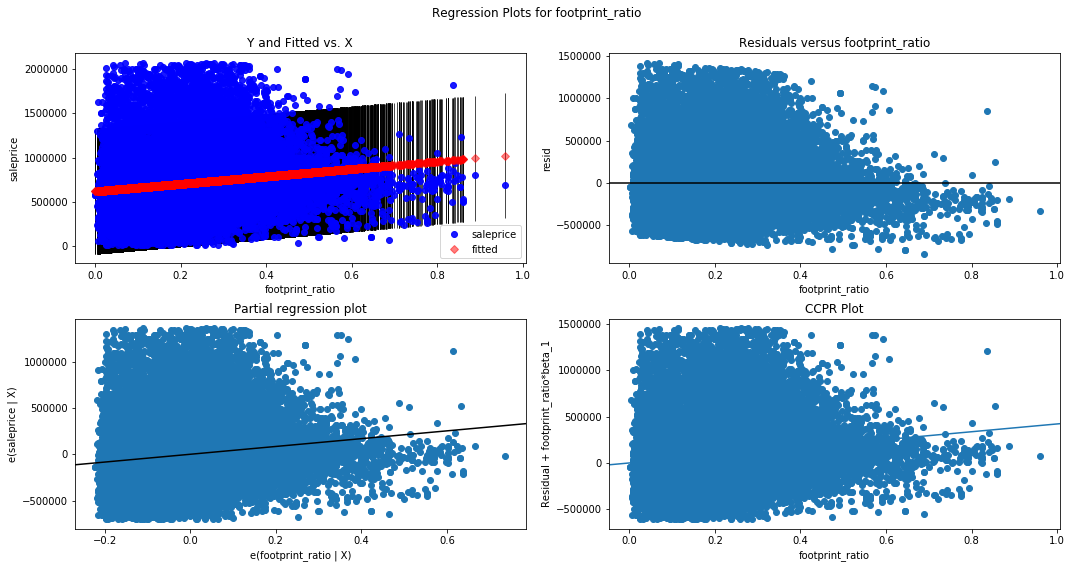

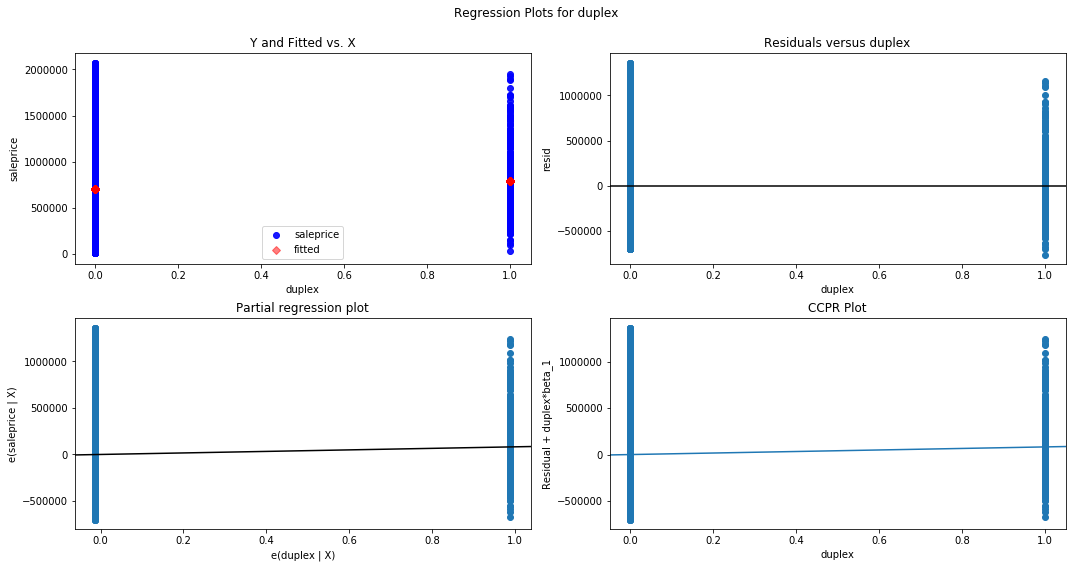

In [19]:
kc.check_feature_heteros(baseline_features, x, y)

### Because the sqftlot feature seems to violoate assumption of linearity, lets remove it from the model

In [20]:
baseline_features = ['sqfttotliving','footprint_ratio','duplex']
kc.make_housing_model(baseline_features, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     4189.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        15:38:24   Log-Likelihood:            -3.9364e+05
No. Observations:               28037   AIC:                         7.873e+05
Df Residuals:                   28033   BIC:                         7.873e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.794e+05   5528.401     32.449      0.000    1.69e+05     1.9e+05
sqfttotliving     223.7781      2.065    108.341      0.000     219.730     227.827
footprint_ratio  2.964e+05   1.49e+04     19.905      0.000    2.67e+05    3.26e+05
duplex           6.775e+04   1.64e+04      4.129      0.000    3.56e+04    9.99e+04
==============================================================================
Omnibus:                     2920.634   Durbin-Watson:                   0.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5951.768
Skew:                           0.673   Prob(JB):                         0.00
Kurtosis:                       4.812   Cond. No.                     2.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# All RE listings include bath count, so lets see how that contributes to our model:

In [22]:
list_of_feat =['bath_total_count', 'sqfttotliving','footprint_ratio','duplex']
kc.make_housing_model(list_of_feat,kc.engineer_total_baths(x),y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     3142.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        15:41:10   Log-Likelihood:            -3.9364e+05
No. Observations:               28037   AIC:                         7.873e+05
Df Residuals:                   28032   BIC:                         7.873e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.782e+05   5765.288     30.905      0.000    1.67e+05    1.89e+05
bath_total_count  2202.5477   2960.992      0.744      0.457   -3601.140    8006.235
sqfttotliving      222.0344      3.124     71.067      0.000     215.911     228.158
footprint_ratio   2.931e+05   1.55e+04     18.893      0.000    2.63e+05    3.24e+05
duplex            6.763e+04   1.64e+04      4.121      0.000    3.55e+04    9.98e+04
==============================================================================
Omnibus:                     2918.702   Durbin-Watson:                   0.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5927.763
Skew:                           0.674   Prob(JB):                         0.00
Kurtosis:                       4.805   Cond. No.                     2.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Total bathrooms does not seem to add much benefit to our model, and it has an elevated p score, so we will not include it in our model. 

# What about the age of the house?

In [45]:
list_of_feat =['sqfttotliving','footprint_ratio','duplex', 'age']
kc.make_housing_model(list_of_feat,kc.engineer_age(x),y)

KeyError: 'yrbuilt'

### Age seems to add a notible boost in the model,and it has a low p score, lets test its assumptions:

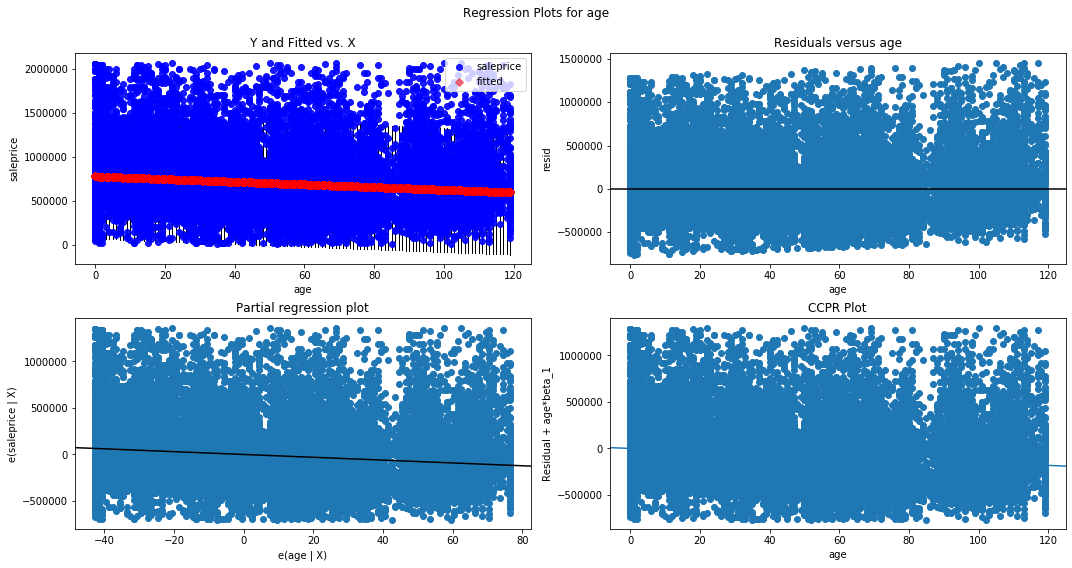

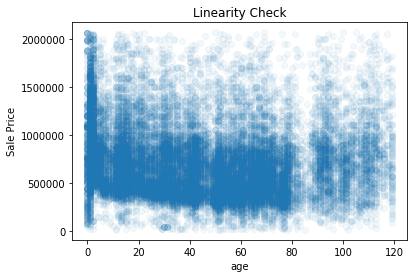

/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/brentsair/Documents/Flatiron_School/mod2/king_county/src/utilities/kc_housing.py:236: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


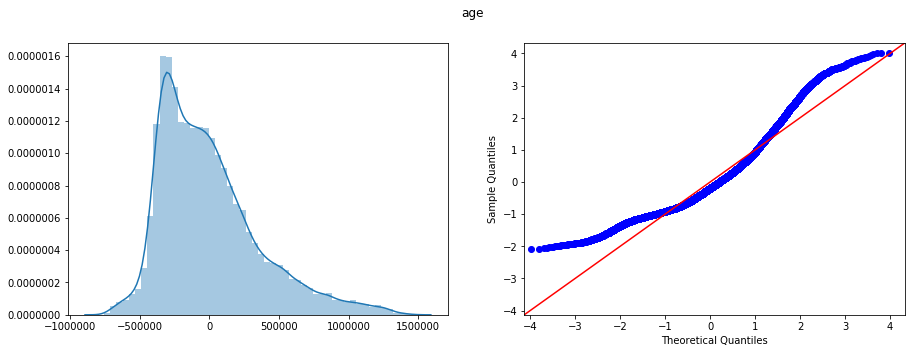

In [46]:
kc.check_feature_heteros(['age'],x,y)
kc.check_feature_linearity(['age'],x,y)
kc.check_feature_resid_dist(['age'],x,y)

### It appears that age violates the assumption of linearity, so although it adds some strength to out R^2 value, we will leave it out of our improved model. 

# What about porches/decks?

In [47]:
list_of_feat =['sqfttotliving','footprint_ratio','duplex', 'porch_sqft_total']
kc.make_housing_model(list_of_feat,kc.engineer_total_porch_space(x),y)

KeyError: 'sqftopenporch'

The R^2 value remains unchanged, and the porch feature's coefficient is relativley small, so we will not include it in the model. 

### Once again, it seems the porch space violates the assumption of linearity, so we will not include it in our final model. 

# How about zipcode? 

In [48]:
#create model with zipcodes and other baseline features

list_of_feat =['sqfttotliving','footprint_ratio','duplex']
kc.make_zipcode_model(df_clean, list_of_feat)

/Users/brentsair/Documents/Flatiron_School/mod2/king_county/src/utilities/kc_housing.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dropped_rows['zipcode'] = dropped_rows['zipcode'].map(lambda x: x[0:5])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     583.8
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:12:22   Log-Likelihood:            -3.1354e+05
No. Observations:               23004   AIC:                         6.273e+05
Df Residuals:                   22919   BIC:                         6.279e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.221e+05   2.01e+05      3.585      0.000    3.27e+05    1.12e+06
zip_98001       -6.955e+05   2.02e+05     -3.451      0.001   -1.09e+06      -3e+05
zip_98002       -6.842e+05   2.02e+05     -3.394      0.001   -1.08e+06   -2.89e+05
zip_98003       -6.817e+05   2.02e+05     -3.382      0.001   -1.08e+06   -2.87e+05
zip_98004        1.382e+05   2.02e+05      0.684      0.494   -2.58e+05    5.34e+05
zip_98005       -1.428e+04   2.02e+05     -0.071      0.944    -4.1e+05    3.82e+05
zip_98006       -1.328e+05   2.02e+05     -0.659      0.510   -5.28e+05    2.62e+05
zip_98007       -2.261e+05   2.02e+05     -1.119      0.263   -6.22e+05     1.7e+05
zip_98008       -2.379e+05   2.02e+05     -1.179      0.238   -6.33e+05    1.57e+05
zip_98009       -6.708e+05   2.85e+05     -2.356      0.019   -1.23e+06   -1.13e+05
zip_98010       -5.779e+05   2.02e+05     -2.857      0.004   -9.74e+05   -1.81e+05
zip_98011       -4.324e+05   2.02e+05     -2.142      0.032   -8.28e+05   -3.68e+04
zip_98014       -5.124e+05   2.02e+05     -2.533      0.011   -9.09e+05   -1.16e+05
zip_98019       -5.346e+05   2.02e+05     -2.647      0.008   -9.31e+05   -1.39e+05
zip_98022       -6.703e+05   2.02e+05     -3.324      0.001   -1.07e+06   -2.75e+05
zip_98023       -6.953e+05   2.01e+05     -3.451      0.001   -1.09e+06      -3e+05
zip_98024       -4.823e+05   2.03e+05     -2.372      0.018   -8.81e+05   -8.38e+04
zip_98027       -3.403e+05   2.02e+05     -1.687      0.092   -7.36e+05     5.5e+04
zip_98028       -4.583e+05   2.02e+05     -2.272      0.023   -8.54e+05   -6.29e+04
zip_98029       -2.531e+05   2.02e+05     -1.254      0.210   -6.49e+05    1.42e+05
zip_98030       -6.644e+05   2.02e+05     -3.294      0.001   -1.06e+06   -2.69e+05
zip_98031       -6.589e+05   2.02e+05     -3.268      0.001   -1.05e+06   -2.64e+05
zip_98032       -6.748e+05   2.02e+05     -3.344      0.001   -1.07e+06   -2.79e+05
zip_98033          95.0037   2.02e+05      0.000      1.000   -3.95e+05    3.95e+05
zip_98034       -3.353e+05   2.02e+05     -1.664      0.096    -7.3e+05    5.97e+04
zip_98038       -6.116e+05   2.02e+05     -3.035      0.002   -1.01e+06   -2.17e+05
zip_98039        4.453e+05   2.08e+05      2.142      0.032    3.77e+04    8.53e+05
zip_98040        1.327e+05   2.02e+05      0.658      0.511   -2.63e+05    5.28e+05
zip_98042       -6.607e+05   2.01e+05     -3.279      0.001   -1.06e+06   -2.66e+05
zip_98045       -4.544e+05   2.02e+05     -2.253      0.024    -8.5e+05   -5.91e+04
zip_98047       -6.979e+05   2.03e+05     -3.436      0.001    -1.1e+06      -3e+05
zip_98050       -4.584e+05   2.33e+05     -1.971      0.049   -9.14e+05   -2649.042
zip_98051       -6.129e+05   2.05e+05     -2.989      0.003   -1.01e+06   -2.11e+05
zip_98052        -2.31e+05   2.02e+05     -1.146      0.252

### LOCATION LOCATION LOCATION wow, that added a bunch to our R^2! Lets check the assumptions: 

/Users/brentsair/Documents/Flatiron_School/mod2/king_county/src/utilities/kc_housing.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dropped_rows['zipcode'] = dropped_rows['zipcode'].map(lambda x: x[0:5])
/Users/brentsair/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


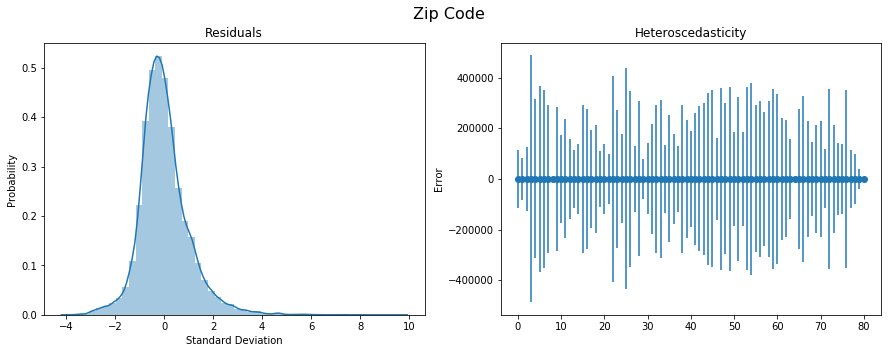

In [49]:
kc.check_zip_code_res_normality(df_clean)


Great, Zip Codes seem to meet our assumptions, lets include them !

# We now added features relating to views, the best predicting waterfront feature, as well as heatsource and the surface of the access street

We tried a model with ALL features not dropped by our cleaning function, and a few stood out. We wanted to explore the street surface and heatsource features, as they were categorical. Upon looking closely at them, they didn't actually improve our R^2 when added alongside the view and waterfront features.

We did not include some view features
